In [1]:
from collections import defaultdict

import networkx as nx
from scipy.sparse import linalg as scp_sla
import numpy as np
import matplotlib.pyplot as plt

import sim_lib.util as util
import sim_lib.graph_networkx as gnx
import sim_lib.attr_lib.util as alu
from sim_lib.attr_lib.formation import *
import sim_lib.attr_lib.vis as vis

In [2]:
_N = 16

# Simul + some vis parameters
num_iters = 10
add_to_iter = 0
show_last = 0
show_every = 1
log_last = 0
log_every = 0

similarity_homophily, similarity_heterophily = alu.gen_similarity_funcs()
schelling_homophily, schelling_heterophily = alu.gen_schelling_seg_funcs(1.0, 'satisfice')

attr_edge_func = similarity_heterophily
attr_total_func = schelling_heterophily
struct_func = alu.ball2_size

params = {
    'context_count' : 2, # Needed for simple utility
    'k' : 1, # Needed for simple attribute utility
    'edge_selection' : alu.seq_projection_edge_edit,
    'attr_copy' : alu.freq_attr_copy,
    'seed_type' : 'grid', # Type of seed network
    'max_clique_size' : 5,
    'revelation_proposals' : alu.resistance_distance_revelation,
    'util_agg' : lambda a, s, c: a + s, # How to aggregate utility values
    'vtx_types' :
        {
            'type1' : { 'likelihood' : 0.5,
                      'struct_util' : struct_func,
                      'init_attrs' : alu.init_cont_heterophily, # context 1
                      'edge_attr_util' : attr_edge_func,
                      'total_attr_util' : attr_total_func,
                      'color' : 'blue' },
            'type0' : { 'likelihood' : 0.5,
                      'struct_util' : struct_func,
                      'init_attrs' : alu.init_cont_homophily, # context 0
                      'edge_attr_util' : attr_edge_func,
                      'total_attr_util' : attr_total_func,
                      'color' : 'red' }
        }
}

assert sum([ t['likelihood'] for t in params['vtx_types'].values() ]) == 1.0

In [3]:
def graph_density(G_nxc):
    denum = (len(G_nxc.nodes) * (len(G_nxc.nodes) - 1))
    num = sum([ G_nxc.degree[v] for v in G_nxc.nodes])
    if denum == 0:
        return -1
    return num / denum

def second_eigv(G_nx):
    try:
        laplacian = nx.linalg.laplacianmatrix.normalized_laplacian_matrix(G_nx)
        eigvals = scp_sla.eigs(laplacian.toarray(), return_eigenvectors=False)
        eigvals.sort()
        return eigvals[1]
    except:
        return -1

def apl(G_nx):
    return nx.average_shortest_path_length(G_nx)

def diam(G_nx):
    return nx.diameter(G_nx)

def bipartite_check(G_nx):
    return nx.is_bipartite(G_nx)

def modularity(G_nx):
    partitions = nx_comm.greedy_modularity_communities(G_nx)
    return nx_comm.modularity(G_nx, partitions)

def total_struct_util(G):
    return sum([ u.data['struct_util'](u, G) for u in G.vertices ])

def total_attribute_util(G):
    return sum([ u.data['total_attr_util'](u, G) for u in G.vertices ])

def average_neighborhood_overlap(G_nxc):
    nbor_overlaps = []
    vertices = list(G_nxc.nodes)
    for u_idx, u in enumerate(vertices):
        for v in vertices[u_idx + 1:]:
            nbor_overlaps.append(len(list(nx.common_neighbors(G_nxc, u, v))))
    return sum(nbor_overlaps) / len(vertices)

def print_metrics(G):
    G_nx = gnx.graph_to_nx(G)
    G_nx_comp_nodes = list(nx.connected_components(G_nx))
    G_nx_largest = G_nx.subgraph(max(G_nx_comp_nodes, key=len))
    G_nx_comps = [ G_nx.subgraph(G_nxc_nodes) for G_nxc_nodes in G_nx_comp_nodes ]
    
    component_sizes = [ len(G_nxc) for G_nxc in G_nx_comps ]
    gd = [ graph_density(G_nxc) for G_nxc in G_nx_comps ]
    avg_pl = apl(G_nx_largest)
    diameter = diam(G_nx_largest)
    eig2 = second_eigv(G_nx_largest)
    tsu = total_struct_util(G)
    tau = total_attribute_util(G)
    is_bp = bipartite_check(G_nx)
    anl = [ average_neighborhood_overlap(G_nxc) for G_nxc in G_nx_comps ]
    
    print(f"""Largest component size: {component_sizes}
graph density: {gd}, \n
average path length: {avg_pl}, \n
diameter: {diameter}, \n
second eigenvalue: {eig2} \n
total structural util: {tsu} \n
total attribute util: {tau} \n
is bipartite: {is_bp} \n
avg nbor overlap: {anl}\n""")

In [4]:
def plot_distributions(G):
    
    # Degree distribution
    degree_dist = [ v.degree for v in G.vertices ]
    norm_degree_dist = []
    if max(degree_dist) == 0:
        norm_degree_dist = [ 0 for d in degree_dist ]
    else:
        norm_degree_dist = [ d / max(degree_dist) for d in degree_dist ]
    
    G_nx = gnx.graph_to_nx(G)
    eigv_centralities = nx.eigenvector_centrality(G_nx, weight='util')
    eigv_centralities = list(eigv_centralities.values())
    
    metric_dists = [norm_degree_dist, eigv_centralities]
    dist_labels = ['norm degree', 'eigenvector cent']
    
    bins = np.linspace(0, 1, 100)
    plt.hist(metric_dists, bins, alpha=0.5, label=dist_labels)
    plt.legend(loc='upper right')
    plt.show()
    

{'context_count': 2, 'k': 1, 'edge_selection': <function seq_projection_edge_edit at 0x7fd801cd2048>, 'attr_copy': <function freq_attr_copy at 0x7fd801cd2378>, 'seed_type': 'grid', 'max_clique_size': 5, 'revelation_proposals': <function resistance_distance_revelation at 0x7fd801cd2158>, 'util_agg': <function <lambda> at 0x7fd801c69158>, 'vtx_types': {'type1': {'likelihood': 0.5, 'struct_util': <function ball2_size at 0x7fd801cd0b70>, 'init_attrs': <function init_cont_heterophily at 0x7fd801cd0400>, 'edge_attr_util': <function gen_similarity_funcs.<locals>.heterophily at 0x7fd801c69048>, 'total_attr_util': <function gen_schelling_seg_funcs.<locals>.schelling_balance at 0x7fd801c690d0>, 'color': 'blue'}, 'type0': {'likelihood': 0.5, 'struct_util': <function ball2_size at 0x7fd801cd0b70>, 'init_attrs': <function init_cont_homophily at 0x7fd801cd0378>, 'edge_attr_util': <function gen_similarity_funcs.<locals>.heterophily at 0x7fd801c69048>, 'total_attr_util': <function gen_schelling_seg_fu

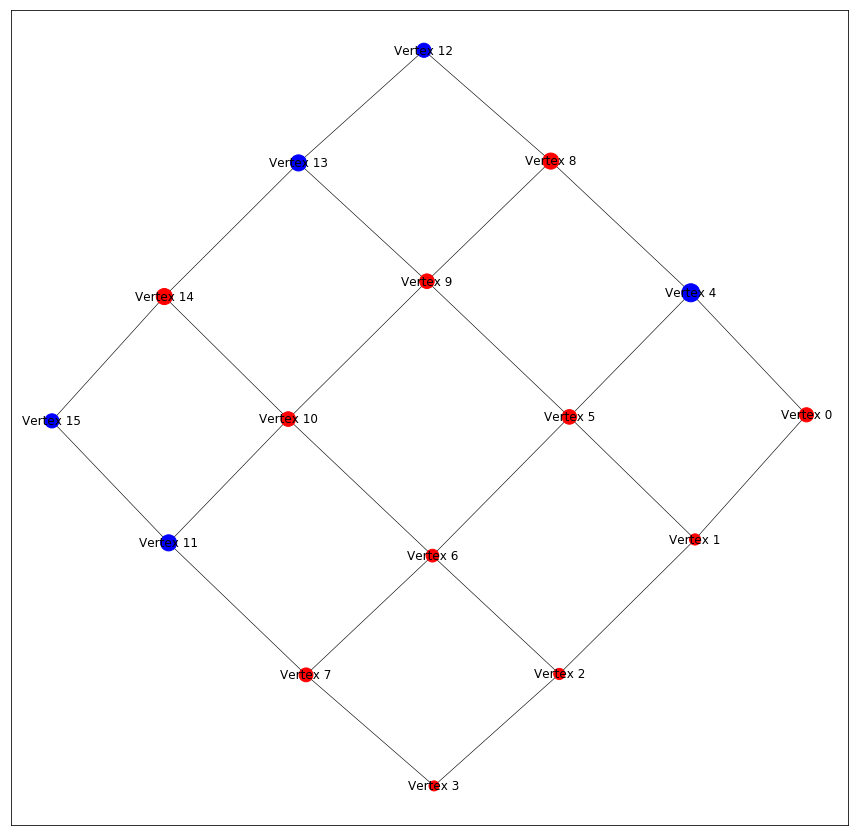

{Vertex 2: [Vertex 11], Vertex 3: [Vertex 15], Vertex 14: [Vertex 7], Vertex 15: [Vertex 0], Vertex 4: [Vertex 2], Vertex 5: [Vertex 11], Vertex 8: [Vertex 3], Vertex 6: [Vertex 15], Vertex 7: [Vertex 9], Vertex 12: [Vertex 5], Vertex 9: [Vertex 0], Vertex 10: [Vertex 1], Vertex 11: [Vertex 12], Vertex 0: [Vertex 6], Vertex 1: [Vertex 8], Vertex 13: [Vertex 11]}
Iteration: 0
Largest component size: [16]
graph density: [0.225], 

average path length: 2.1083333333333334, 

diameter: 4, 

second eigenvalue: (1.4124275266389585+0j) 

total structural util: 11.5 

total attribute util: 13.65 

is bipartite: False 

avg nbor overlap: [5.1875]



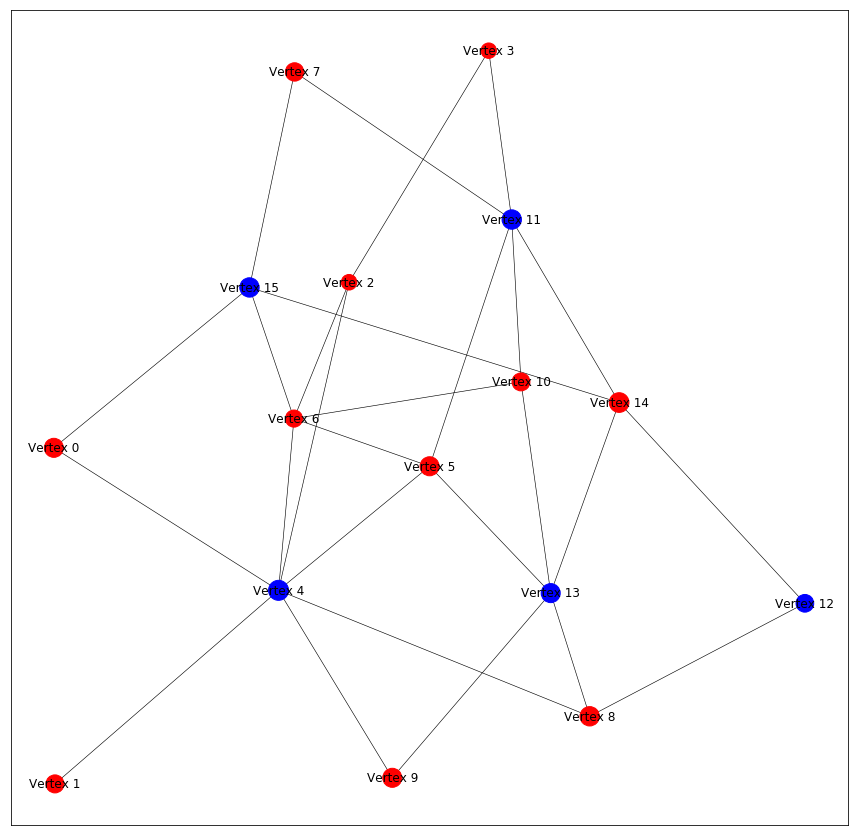

{Vertex 2: [Vertex 13], Vertex 3: [Vertex 8], Vertex 14: [Vertex 2], Vertex 15: [Vertex 3], Vertex 4: [Vertex 14], Vertex 5: [Vertex 12], Vertex 8: [Vertex 11], Vertex 6: [Vertex 12], Vertex 7: [Vertex 8], Vertex 12: [Vertex 0], Vertex 9: [Vertex 7], Vertex 10: [Vertex 0], Vertex 11: [Vertex 1], Vertex 0: [Vertex 10], Vertex 1: [Vertex 11], Vertex 13: [Vertex 1]}
Iteration: 1
Largest component size: [16]
graph density: [0.20833333333333334], 

average path length: 2.325, 

diameter: 4, 

second eigenvalue: (1.3775402058690491+0j) 

total structural util: 10.125 

total attribute util: 16.0 

is bipartite: True 

avg nbor overlap: [4.5]



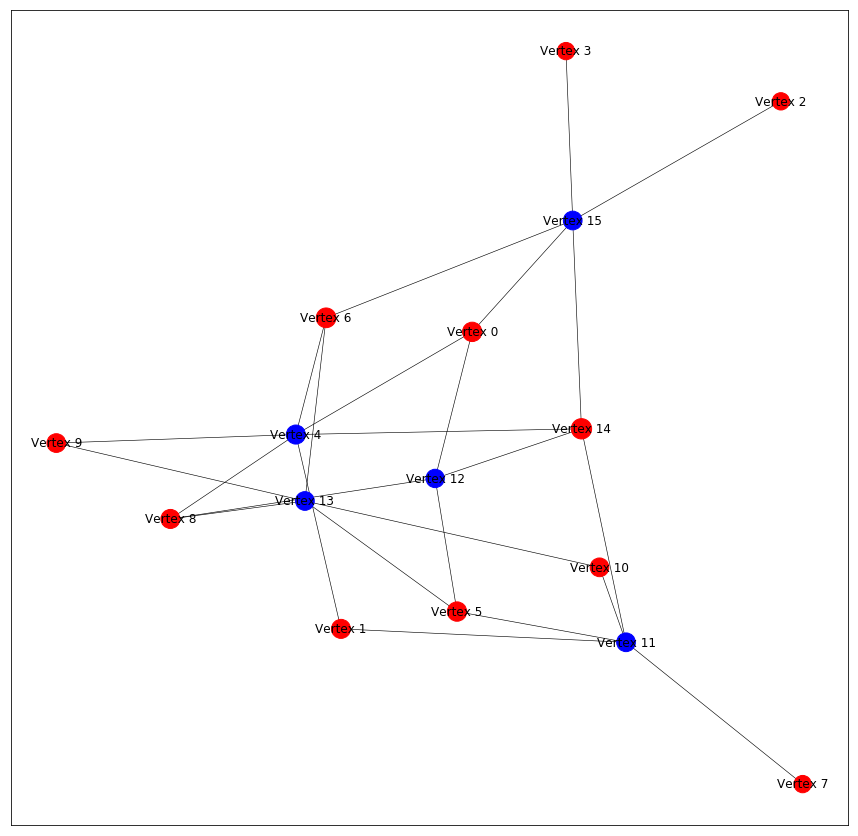

{Vertex 2: [Vertex 7], Vertex 3: [Vertex 4], Vertex 14: [Vertex 13], Vertex 15: [Vertex 1], Vertex 4: [Vertex 5], Vertex 5: [Vertex 4], Vertex 8: [Vertex 15], Vertex 6: [Vertex 12], Vertex 7: [Vertex 6], Vertex 12: [Vertex 1], Vertex 9: [Vertex 12], Vertex 10: [Vertex 4], Vertex 11: [Vertex 3], Vertex 0: [Vertex 13], Vertex 1: [Vertex 12], Vertex 13: [Vertex 14]}
Iteration: 2
Largest component size: [15, 1]
graph density: [0.23809523809523808, -1], 

average path length: 2.1619047619047618, 

diameter: 4, 

second eigenvalue: (1.1216117703255968+0j) 

total structural util: 10.0625 

total attribute util: 14.600000000000001 

is bipartite: False 

avg nbor overlap: [5.133333333333334, 0.0]



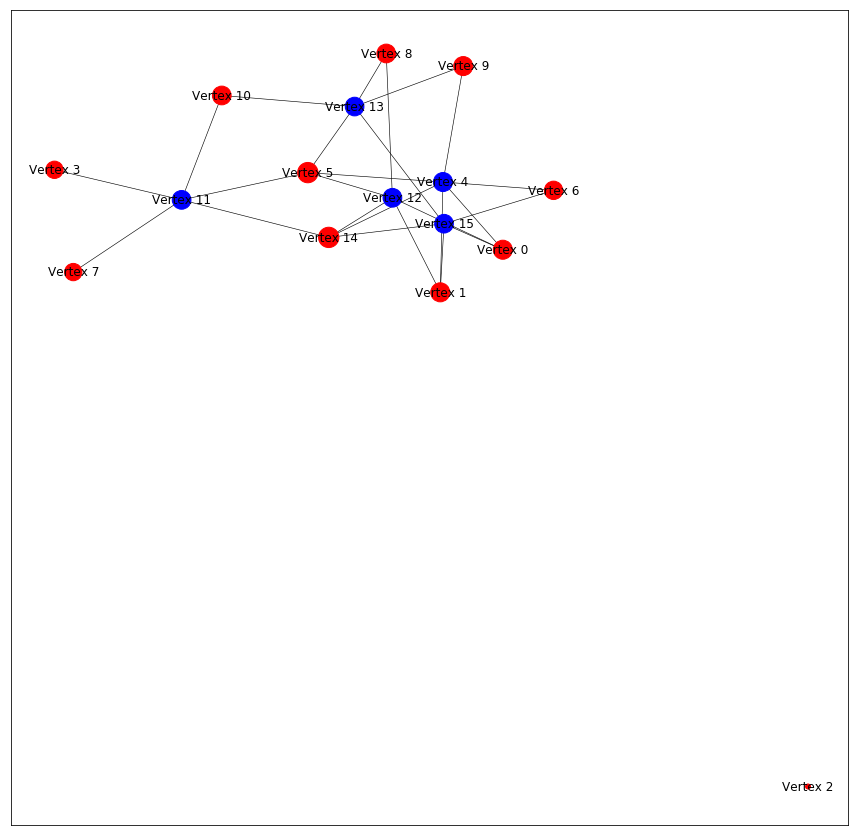

{Vertex 2: [Vertex 8], Vertex 3: [Vertex 15], Vertex 14: [Vertex 2], Vertex 15: [Vertex 3], Vertex 4: [Vertex 8], Vertex 5: [Vertex 2], Vertex 8: [Vertex 6], Vertex 6: [Vertex 12], Vertex 7: [Vertex 2], Vertex 12: [Vertex 2], Vertex 9: [Vertex 12], Vertex 10: [Vertex 0], Vertex 11: [Vertex 0], Vertex 0: [Vertex 10], Vertex 1: [Vertex 7], Vertex 13: [Vertex 3]}
Iteration: 3
Largest component size: [16]
graph density: [0.225], 

average path length: 2.275, 

diameter: 4, 

second eigenvalue: (1.2529249586352476+0j) 

total structural util: 10.5 

total attribute util: 16.0 

is bipartite: True 

avg nbor overlap: [5.5]



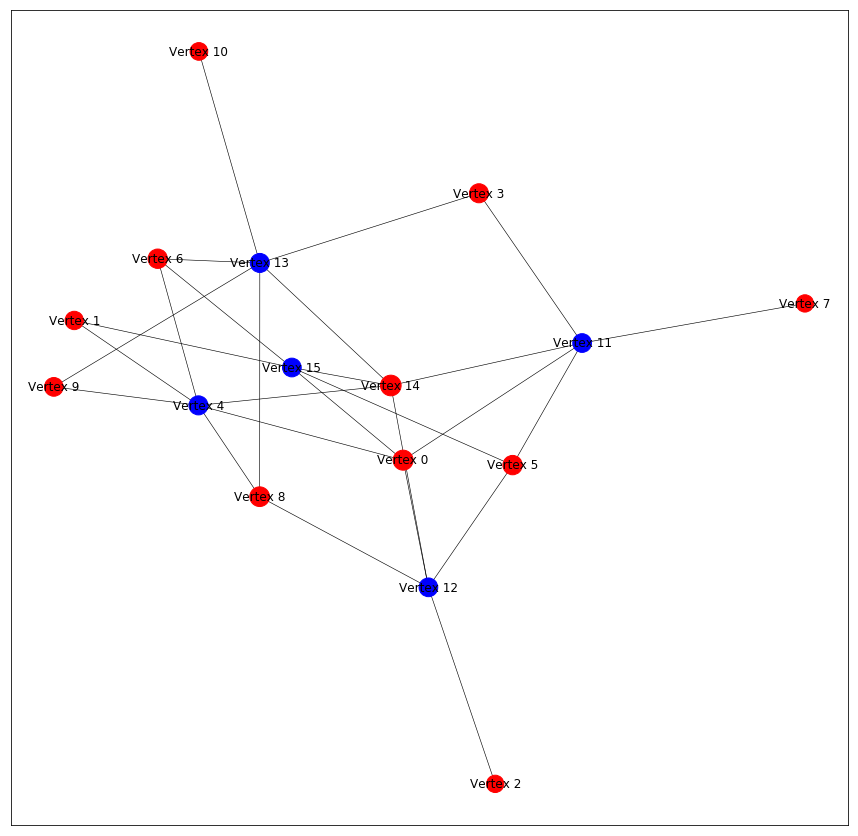

{Vertex 2: [Vertex 9], Vertex 3: [Vertex 12], Vertex 14: [], Vertex 15: [Vertex 3], Vertex 4: [Vertex 3], Vertex 5: [Vertex 4], Vertex 8: [Vertex 15], Vertex 6: [Vertex 12], Vertex 7: [Vertex 2], Vertex 12: [Vertex 3], Vertex 9: [Vertex 5], Vertex 10: [Vertex 0], Vertex 11: [Vertex 8], Vertex 0: [Vertex 13], Vertex 1: [Vertex 12], Vertex 13: [Vertex 5]}
Iteration: 4
Largest component size: [16]
graph density: [0.20833333333333334], 

average path length: 2.375, 

diameter: 4, 

second eigenvalue: (1.3205603435625646+0j) 

total structural util: 9.75 

total attribute util: 16.0 

is bipartite: True 

avg nbor overlap: [4.5625]



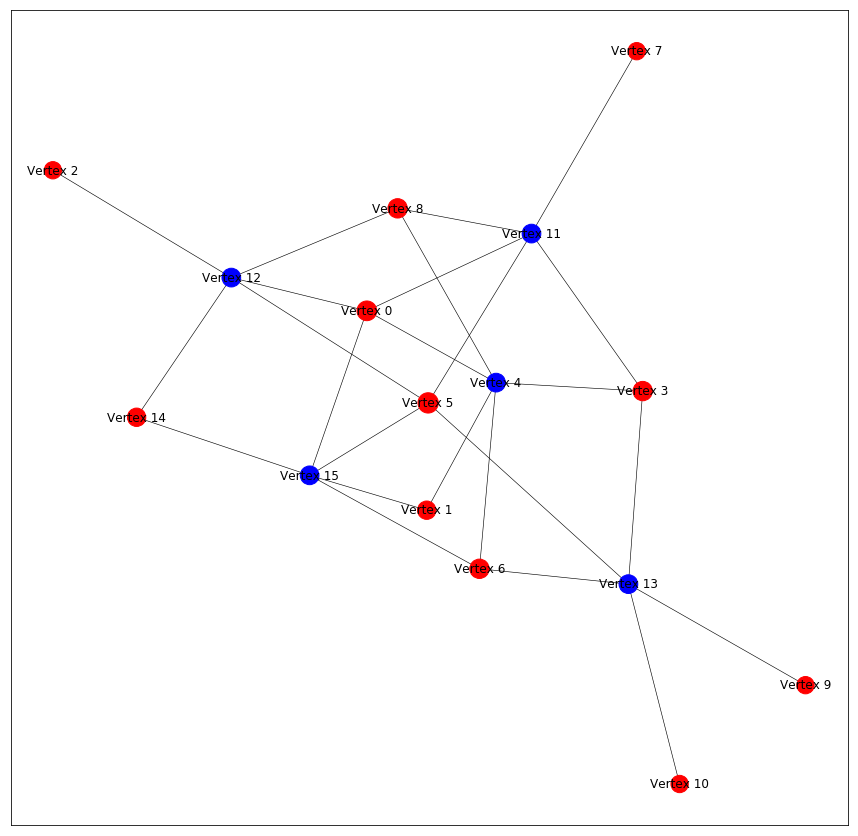

{Vertex 2: [Vertex 15], Vertex 3: [Vertex 12], Vertex 14: [Vertex 4], Vertex 15: [Vertex 3], Vertex 4: [Vertex 7], Vertex 5: [Vertex 4], Vertex 8: [Vertex 13], Vertex 6: [Vertex 11], Vertex 7: [Vertex 14], Vertex 12: [Vertex 6], Vertex 9: [Vertex 2], Vertex 10: [Vertex 12], Vertex 11: [Vertex 2], Vertex 0: [Vertex 13], Vertex 1: [Vertex 7], Vertex 13: [Vertex 14]}
Iteration: 5
Largest component size: [16]
graph density: [0.225], 

average path length: 2.183333333333333, 

diameter: 4, 

second eigenvalue: (1.3224555694126605+0j) 

total structural util: 11.0 

total attribute util: 15.666666666666668 

is bipartite: False 

avg nbor overlap: [5.625]



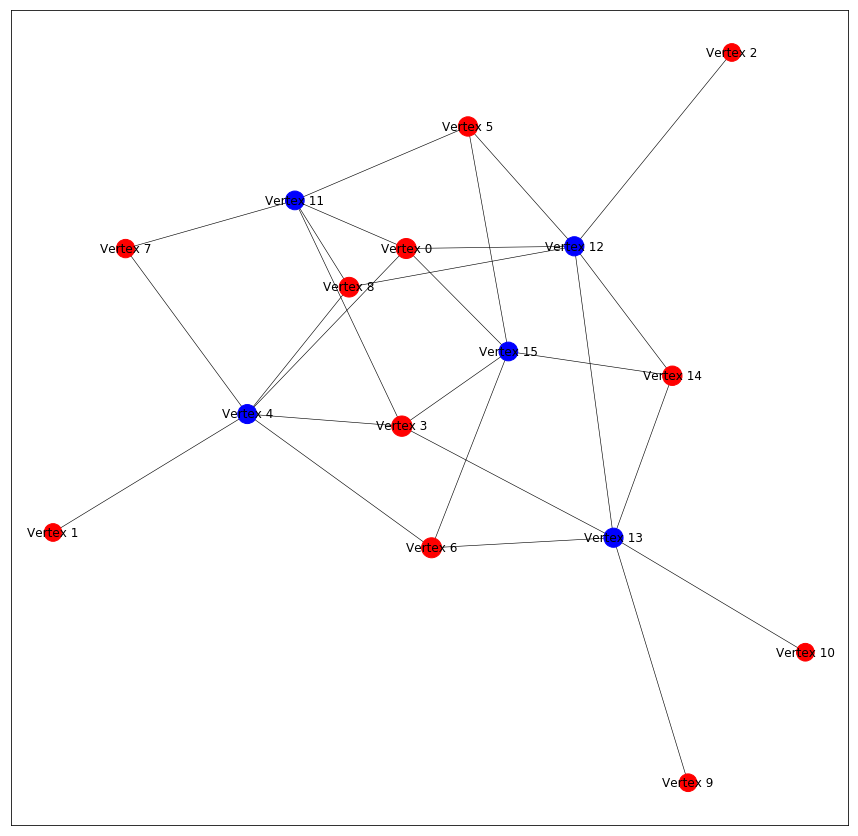

{Vertex 2: [Vertex 11], Vertex 3: [Vertex 2], Vertex 14: [Vertex 4], Vertex 15: [Vertex 2], Vertex 4: [Vertex 5], Vertex 5: [Vertex 4], Vertex 8: [Vertex 15], Vertex 6: [Vertex 2], Vertex 7: [Vertex 15], Vertex 12: [Vertex 1], Vertex 9: [Vertex 8], Vertex 10: [Vertex 11], Vertex 11: [Vertex 1], Vertex 0: [Vertex 9], Vertex 1: [Vertex 12], Vertex 13: [Vertex 7]}
Iteration: 6
Largest component size: [15, 1]
graph density: [0.23809523809523808, -1], 

average path length: 2.1619047619047618, 

diameter: 4, 

second eigenvalue: (1.256774065974974+0j) 

total structural util: 9.8125 

total attribute util: 14.600000000000001 

is bipartite: False 

avg nbor overlap: [5.266666666666667, 0.0]



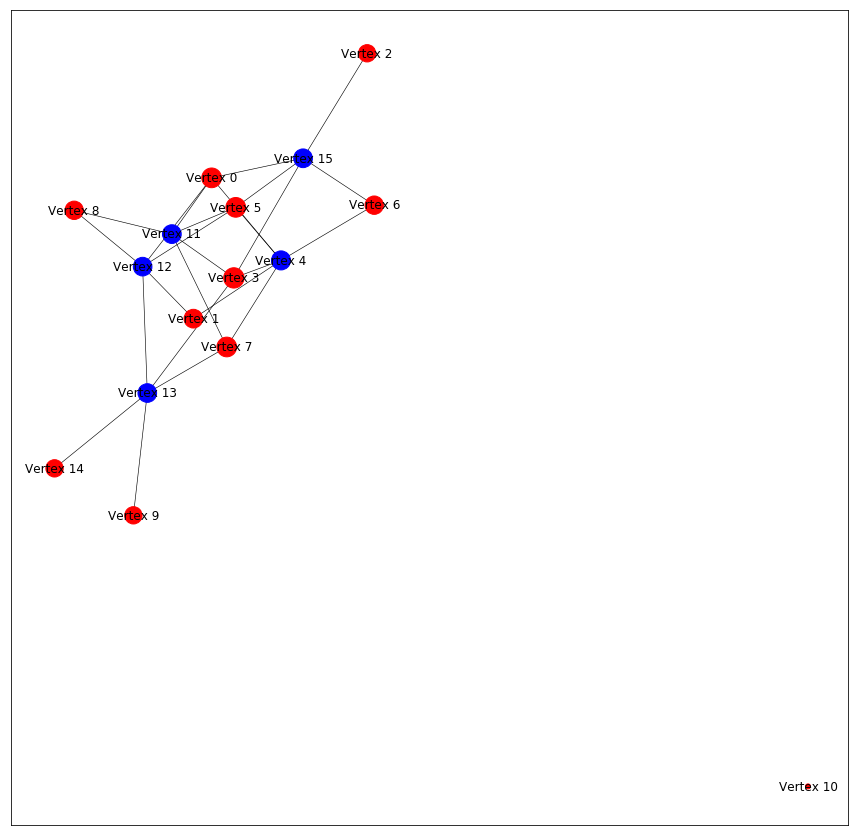

{Vertex 2: [Vertex 10], Vertex 3: [Vertex 10], Vertex 14: [Vertex 11], Vertex 15: [Vertex 8], Vertex 4: [Vertex 2], Vertex 5: [Vertex 10], Vertex 8: [Vertex 10], Vertex 6: [Vertex 13], Vertex 7: [Vertex 15], Vertex 12: [Vertex 6], Vertex 9: [Vertex 10], Vertex 10: [Vertex 4], Vertex 11: [Vertex 14], Vertex 0: [Vertex 9], Vertex 1: [Vertex 11], Vertex 13: [Vertex 2]}
Iteration: 7
Largest component size: [15, 1]
graph density: [0.22857142857142856, -1], 

average path length: 2.2666666666666666, 

diameter: 4, 

second eigenvalue: (1.2600970841505093+0j) 

total structural util: 9.1875 

total attribute util: 15.0 

is bipartite: True 

avg nbor overlap: [4.6, 0.0]



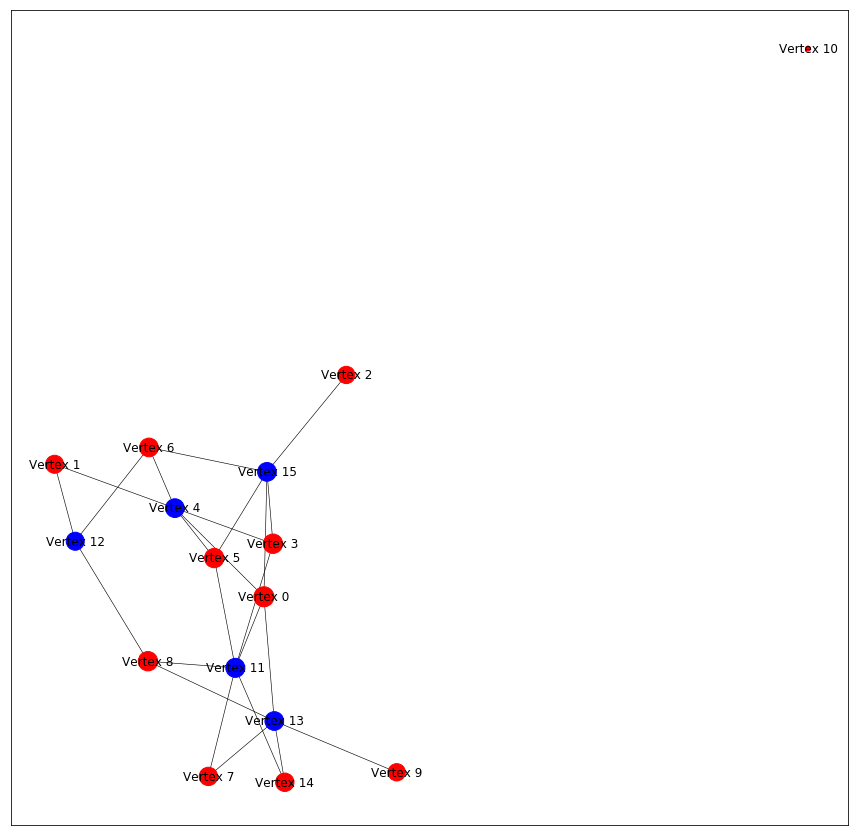

{Vertex 2: [Vertex 11], Vertex 3: [Vertex 13], Vertex 14: [Vertex 10], Vertex 15: [Vertex 1], Vertex 4: [Vertex 10], Vertex 5: [Vertex 12], Vertex 8: [Vertex 4], Vertex 6: [Vertex 7], Vertex 7: [Vertex 15], Vertex 12: [Vertex 5], Vertex 9: [Vertex 4], Vertex 10: [Vertex 15], Vertex 11: [Vertex 2], Vertex 0: [Vertex 12], Vertex 1: [Vertex 7], Vertex 13: [Vertex 6]}
Iteration: 8
Largest component size: [15, 1]
graph density: [0.23809523809523808, -1], 

average path length: 2.057142857142857, 

diameter: 4, 

second eigenvalue: (1.147329356958428+0j) 

total structural util: 10.4375 

total attribute util: 14.633333333333333 

is bipartite: False 

avg nbor overlap: [5.0, 0.0]



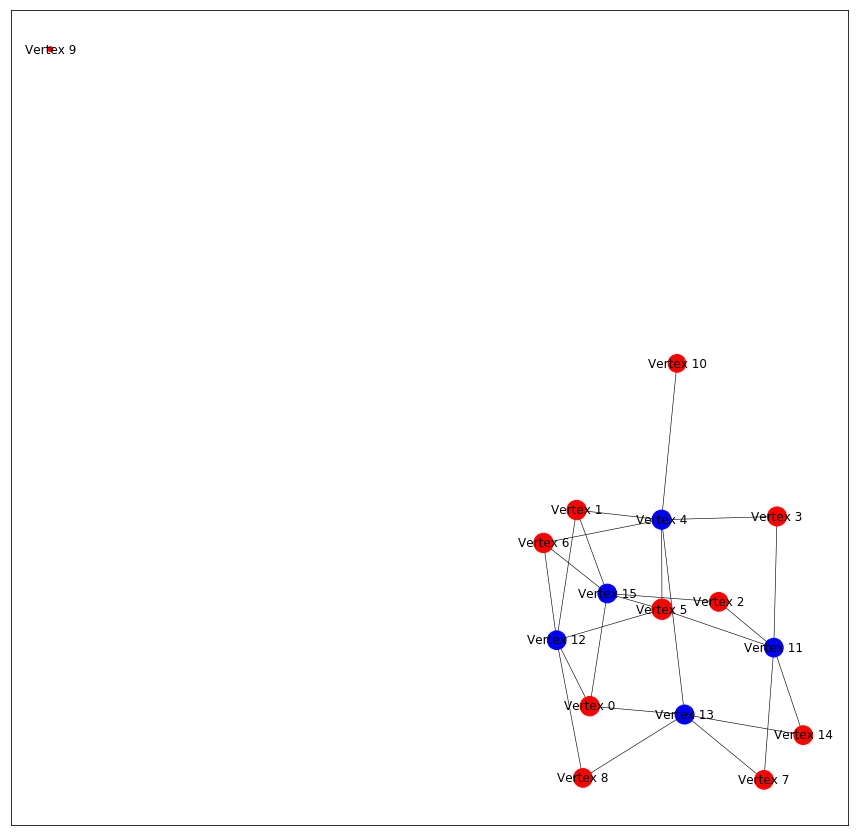

{Vertex 2: [Vertex 12], Vertex 3: [Vertex 12], Vertex 14: [Vertex 12], Vertex 15: [Vertex 3], Vertex 4: [Vertex 9], Vertex 5: [Vertex 9], Vertex 8: [Vertex 11], Vertex 6: [Vertex 11], Vertex 7: [Vertex 9], Vertex 12: [Vertex 3], Vertex 9: [Vertex 15], Vertex 10: [Vertex 15], Vertex 11: [Vertex 6], Vertex 0: [Vertex 10], Vertex 1: [Vertex 14], Vertex 13: [Vertex 2]}
Iteration: 9
Largest component size: [16]
graph density: [0.20833333333333334], 

average path length: 2.2416666666666667, 

diameter: 4, 

second eigenvalue: (1.2436198247107335+0j) 

total structural util: 10.5 

total attribute util: 15.633333333333333 

is bipartite: False 

avg nbor overlap: [4.75]



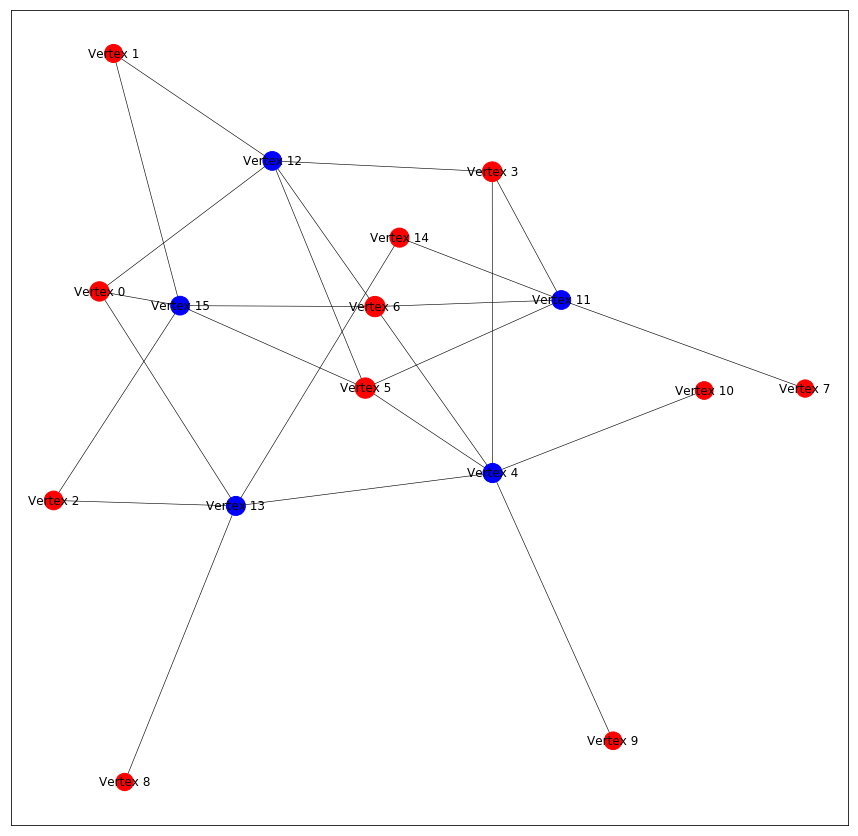

Final unique attribute counts (summed)
[]


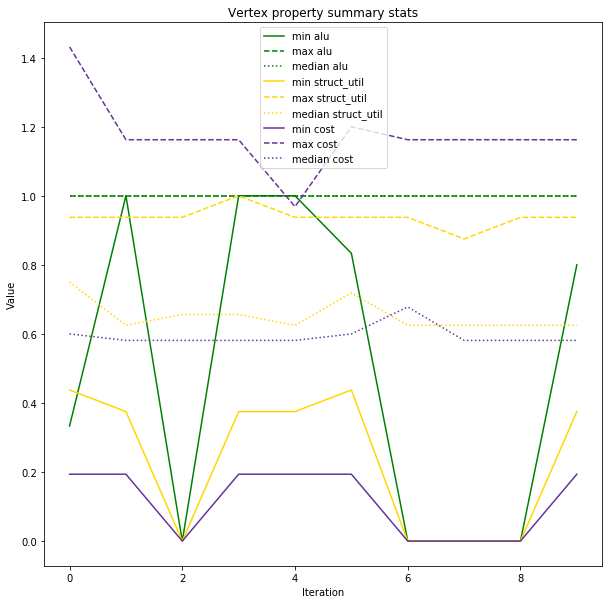

<Figure size 720x720 with 0 Axes>

In [5]:
G = attribute_network(_N, params)
print(G.sim_params)

summary_stat_vals = ['alu', 'struct_util', 'cost']
summary_funcs = [ min, max, np.median ]
summary_func_names = ['min', 'max', 'median']
summary_stats = { val : { name : [] for name in summary_func_names } \
                 for val in summary_stat_vals }
stat_val_colors = ['green', 'gold', 'rebeccapurple']
summary_func_styles = ['-', '--', ':']

print('Initial graph')
vis.draw_graph(G)
for it in range(num_iters):
    if it < add_to_iter:
        add_attr_graph_vtx(G)
        
    meets_log = (log_every != 0) and ((it % log_every == 0) or (it >= num_iters - log_last))
    if meets_log:
        G.sim_params['edge_selection'] = alu.seq_edge_sel_logged
    else:
        G.sim_params['edge_selection'] = alu.seq_edge_sel_silent
    
    calc_edges(G)
        
    # Sim iter end, start stat collection
    attr_util_vals = [ u.data['total_attr_util'](u, G) for u in G.vertices ]
    struct_util_vals = [ u.data['struct_util'](u, G) for u in G.vertices ]
    costs = [ alu.calc_cost(u, G) for u in G.vertices ]
    values = [attr_util_vals, struct_util_vals, costs]
    
    for si in range(len(summary_stat_vals)):
        for fi in range(len(summary_funcs)):
            ss_val = summary_funcs[fi](values[si])
            summary_stats[summary_stat_vals[si]][summary_func_names[fi]].append(ss_val)
            
    if it % show_every == 0 or it >= num_iters - show_last:
        print('Iteration:', it)
        print_metrics(G)
        vis.draw_graph(G)

plt.figure(figsize=(10,10))
x_vals = list(range(num_iters))
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("Vertex property summary stats")
for si in range(len(stat_val_colors)):
    for fi in range(len(summary_func_styles)):
        plt.plot(x_vals,
                 summary_stats[summary_stat_vals[si]][summary_func_names[fi]],
                 color=stat_val_colors[si],
                 linestyle=summary_func_styles[fi],
                 label='{0} {1}'.format(summary_func_names[fi], summary_stat_vals[si]))
plt.legend()

plt.figure(figsize=(10,10))
def get_counts(v):
    counts = {}
    for ctxt in v.attr_obs.keys():
        counts[ctxt] = {}
        for attr, obs in v.attr_obs[ctxt].items():
            counts[ctxt][attr] = len(obs)
    return counts

attr_counts = [ get_counts(v) for v in G.vertices ]
final_attr_counts = defaultdict(lambda : 0)
for count_set in attr_counts:
    for attr_obs_counts in count_set.values():
        for attr, attr_cnt in attr_obs_counts.items():
            final_attr_counts[attr] += attr_cnt
print("Final unique attribute counts (summed)")
attr_list = list(final_attr_counts.keys())
attr_list.sort()
attr_count_list = [ final_attr_counts[atr] for atr in attr_list ]
print(list(zip(attr_list, attr_count_list)))

plt.show()